In [1]:
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
# set the random seeds
import numpy as np
np.random.seed(135)
import torch
torch.cuda.manual_seed_all(135)
torch.manual_seed(135)

In [3]:
from data import toyDataset
from model import fcNet, mtlNet
from gradnorm import gradNorm

In [4]:
# init
n = 10000
p = 250
d = 100
sigmas = [48, 3, 54, 16, 9, 30, 52, 26, 47, 81]
#sigmas = [1, 100]

In [5]:
# data
dataset = toyDataset(num_data=n, dim_features=p, dim_labels=d, scalars=sigmas)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [6]:
# model
net = fcNet(p, d, n_tasks=len(sigmas))
print(net)
mtlnet = mtlNet(net)

fcNet(
  (fc1): Linear(in_features=250, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (heads): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Linear(in_features=100, out_features=100, bias=True)
  )
)


In [7]:
log_weights, log_loss = gradNorm(net=mtlnet, layer=net.fc4, alpha=0.12, dataloader=dataloader,
                                 num_epochs=250, lr1=1e-5, lr2=5e-4, log=True)

In [8]:
for x, y in dataloader:
    loss = mtlnet(x, y)
    for i in range(len(loss)):
        print("σ = {:3}, Normalized MSE = {:.4f}".format(sigmas[i], loss[i] / sigmas[i] ** 2))
    break

σ =  48, Normalized MSE = 0.8777
σ =   3, Normalized MSE = 0.4243
σ =  54, Normalized MSE = 0.8890
σ =  16, Normalized MSE = 0.6831
σ =   9, Normalized MSE = 0.5763
σ =  30, Normalized MSE = 0.8204
σ =  52, Normalized MSE = 0.8808
σ =  26, Normalized MSE = 0.7744
σ =  47, Normalized MSE = 0.8639
σ =  81, Normalized MSE = 0.9214


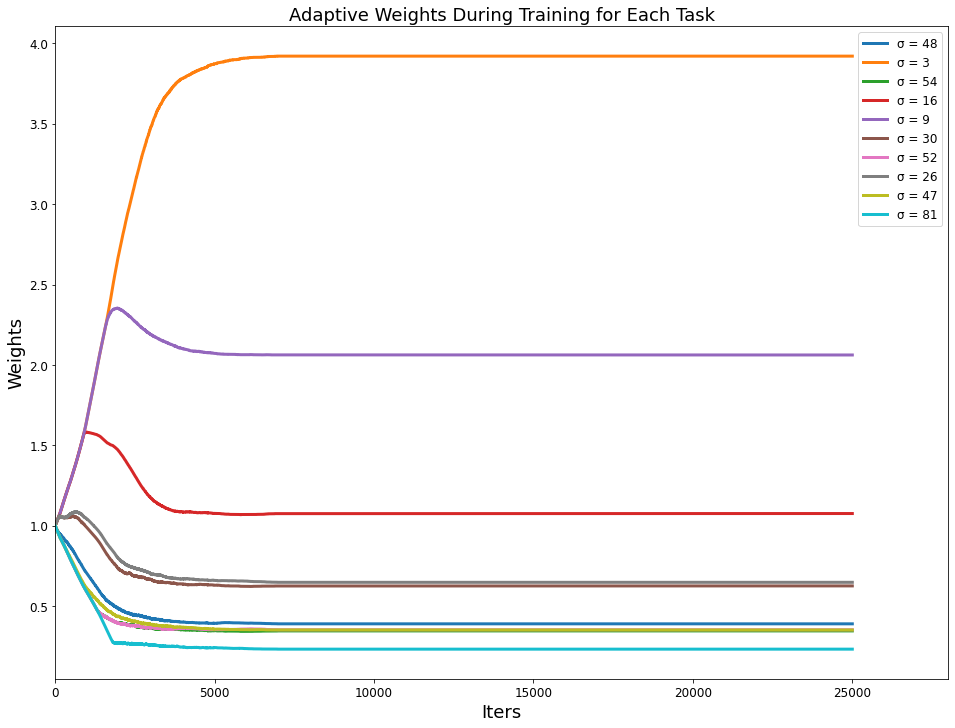

In [9]:
# draw plot
plt.figure(figsize=(16, 12))
for i in range(len(sigmas)):
    plt.plot(log_weights[:,i], lw=3, label="σ = {}".format(sigmas[i]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 28000)
plt.xlabel("Iters", fontsize=18)
plt.ylabel("Weights", fontsize=18)
plt.title("Adaptive Weights During Training for Each Task", fontsize=18)
plt.legend(fontsize=12)
plt.show()

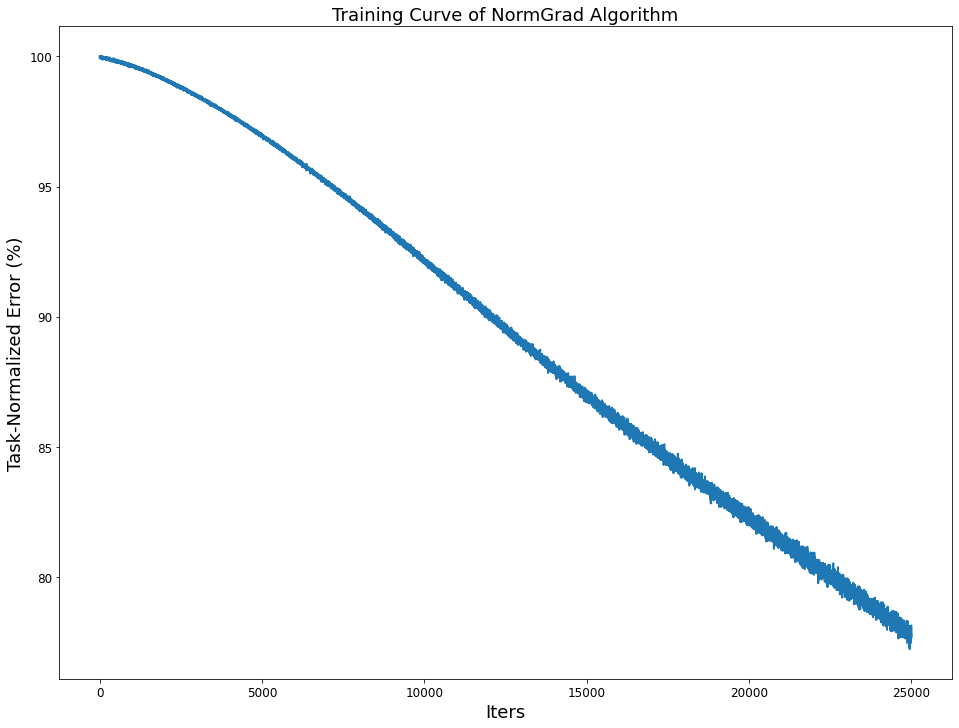

In [10]:
# draw plot
plt.figure(figsize=(16, 12))
plt.plot(log_loss.mean(axis=1)*100, lw=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=18)
plt.ylabel("Task-Normalized Error (%)", fontsize=18)
plt.title("Training Curve of NormGrad Algorithm", fontsize=18)
plt.show()